<a href="https://colab.research.google.com/github/bigblueboo/generative-ai-playground/blob/main/stable_diffusion_explore_interpolate_seeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nov 12, 2022 | @bigblueboo | c. deck**

This notebook explores different ways to interpolate (or "walk" or "tween") between seeds. The approach here consists of transitioning from the initial latent noise of one seed to the other.

Linearly interpolating between noises doesn’t produce good results. This is due to a dynamic of the underlying statistics: averaging two sets of normal distrubtion-sampled random numbers doesn’t give you a similarly-distributed random sample. 

Intuitively, if you average lots of samples from a normal distrubtion, you’ll get closer and closer to the mean. Interpolating between the two torch.randn-generated matrices makes for a latent that’s closer to the mean (0) and the diffusion model doesn’t understand that kind of noise, yielding uninteresting results.



In [45]:
%%html
<video width=512 controls>
<source src="https://thumbs.gfycat.com/BlissfulTediousHorse-mobile.mp4"  type="video/mp4">
</video>

You can see that at 4.5s, in the middle, there’s hardly any image at all.

So in lieu of interpolating the noise, I used a third noise to act as a mask. Instead of interpolating from one seed’s noise to the second’s, I thresholded the mask noise from zero to one. (I ended up doing a kind of soft-threshold, below.)

The mask looks like this, then, as we go from t_seed1 to t_seed2:

In [46]:
%%html
<video width=512 controls>
<source src="https://thumbs.gfycat.com/CaringBelatedLadybug-mobile.mp4">
</video>

(There is a bit of interpolation in the “soft” part of the threshold.)

Here’s what it looks like using the above mask transition from one seed’s initial noise to the next.

In [47]:
%%html
<video width=512 controls>
<source src="https://thumbs.gfycat.com/BossyTinyHagfish-mobile.mp4">
</video>

Below is another improvement: blurring the mask quite significantly (gaussian blur with sigma (3,5)) with a soft threshold.

In [48]:
%%html
<video width=512 controls>
<source src="https://thumbs.gfycat.com/MilkyKnobbyElver-mobile.mp4">
</video>

# Helper functions

In [ ]:
# Install dependencies.
!pip install diffusers transformers fastcore ipdb fastdownload accelerate
import ipdb

In [ ]:
# Let's check and see what GPU we have.
!nvidia-smi

In [3]:
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [4]:
# Imports

import torch
from torchvision import transforms as tfms
from torch import autocast
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
logging.set_verbosity_error()

from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler, DDIMScheduler

# For blurring the mask
from scipy.ndimage import gaussian_filter

# tqdm is that nice progressbar.
from tqdm.auto import tqdm

# Visualization components.
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

# Used for rendering video in the notebook.
from IPython.display import HTML
from base64 import b64encode

In [5]:
# Visualization functions

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

def image_grid(imgs, rows, cols):
  w, h = imgs[0].size
  grid_image = Image.new('RGB', size=(cols*w, rows*h))
  for i, img in enumerate(imgs): grid_image.paste(img, box=(i%cols*w,i//cols*h))
  return grid_image

def add_caption(img, text, padding=2):
  draw = ImageDraw.Draw(img)
  textwidth, textheight = textsize = draw.textsize(text)
  img_height = img.size[1]
  draw.rectangle([( 0,                    img_height-textheight-padding*2),
                    textwidth+padding*2,  img_height],
                    fill=(0,0,0,64))
  draw.text((padding,img_height-textheight-padding), text, fill="white", align="center", anchor="lb") #, font=font)
  return img

from zipfile import ZipFile
import time, os

def zip_folder(path):
  zip_filename = f'/content/download_{str(int(time.time()))[5:]}.zip'

  with ZipFile(zip_filename, 'w') as zip:
    files_to_zip = [path + "/" + filename for filename in os.listdir(path)]
    for file_to_zip in files_to_zip: zip.write(file_to_zip)
    for file_to_zip in files_to_zip: os.unlink(file_to_zip)

def save_img(img, path, filename):
  if not os.path.exists(path):
    os.mkdir(path)
  img.save(path + "/" + filename)

def load_img(path, size):
  """
  Crops to accommodate the aspect ratio indicated by size, then resizes to size.
  """
  img = Image.open(path)
  loaded_aspect_ratio = img.width / img.height
  desired_aspect_ratio = size[0] / size[1]
  if loaded_aspect_ratio > desired_aspect_ratio:
    target_size = (img.height * size[0] / size[1], img.height)
    
    crop_amount = int((img.width-target_size[0]))
    return img.resize(size, Image.BILINEAR, 
                              (crop_amount // 2, 0, img.width - crop_amount // 2, img.height))
  elif loaded_aspect_ratio < desired_aspect_ratio:
    target_size = (img.width,  img.height * size[1] / size[0])
    crop_amount = int((img.height-target_size[1]))
    return img.resize(size, Image.BILINEAR, 
                              (0, crop_amount // 2, img.width, img.height - crop_amount//2))
  elif img.size != size:
    return img.resize(size, Image.BILINEAR)
  else:
    return img

In [6]:
# Encode and decode pixels to/from the VAE's latents.

def latents_to_pil(latents):
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents).sample
  image = (image / 2 + 0.5).clamp(0,1)
  image = image.detach().cpu().permute(0,2,3,1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

def pil_to_latent(input_img, mode="sample"):
  # Single image -> single latent in a batch (so shape 1,4,64,64)
  with torch.no_grad():
    torch_array = tfms.ToTensor()(input_img).unsqueeze(0).to(torch_device)*2-1.0
    latent = vae.encode(torch_array)
  if mode == "sample":
    return 0.18215 * latent.latent_dist.sample()
  elif mode == "mean":
    return 0.18215 * latent.latent_dist.mean
  else:
    raise ValueError("No known mode for " + mode)
    return False


In [7]:
import os

ROOT = os.getcwd() # f"{ROOT}"
IS_GOOGLE = ROOT == "/content"

print(f"Current working directory is {ROOT}. IS_GOOGLE={IS_GOOGLE}")

Current working directory is /content. IS_GOOGLE=True


In [8]:
# Initialize pipeline.
print("Loading VAE...")
model = "runwayml/stable-diffusion-v1-5"
vae = AutoencoderKL.from_pretrained(model, subfolder="vae", 
                                    use_auth_token=access_token)

print("Loading tokenizer...")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", 
                                          use_auth_token=access_token)

print("Loading text_encoder...")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", 
                                             use_auth_token=access_token)

print("Loading unet...")
unet = UNet2DConditionModel.from_pretrained(model, subfolder="unet", 
                                            use_auth_token=access_token)

print("Loading scheduler...")
scheduler = LMSDiscreteScheduler(beta_start=0.00085, 
                                 beta_end=0.012, 
                                 beta_schedule="scaled_linear", 
                                 num_train_timesteps=1000)

scheduler_2 = LMSDiscreteScheduler(beta_start=0.00085, 
                                   beta_end=0.012, 
                                   beta_schedule="scaled_linear", 
                                   num_train_timesteps=1000)

scheduler = DDIMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            num_train_timesteps=1000,
            clip_sample=False,
            set_alpha_to_one=False,
        )

for component in [vae, text_encoder, unet]:
  component.to(torch_device)

print("All done.")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading VAE...


Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Loading text_encoder...


Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading unet...


Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading scheduler...
All done.


# Image and mask generation code

In [139]:
def generate_mask(mode="lerp", mask_strength=0, 
                  blur_sigma=(1,1), threshold_softness=0.1, generator=None):
  if generator is None: generator = torch.manual_seed(time.time())
  m = torch.rand((1,4,64,64), generator=generator)
  x = mask_strength

  if "radial" in mode:
    for i, channel in enumerate(m[0]):
      for j in range(channel.shape[0]):
        for k in range(channel.shape[1]):
          channel[j][k] = ((j+0.5 - channel.shape[0]/2.0)**2 + (k+0.5 - channel.shape[1]/2.0)**2)**0.5 / ((channel.shape[0]/2.0) * (2**0.5) + 1.0)
      m[0][i] = channel
  if "wipe" in mode:
    for i, channel in enumerate(m[0]):
      for j in range(channel.shape[0]):
        for k in range(channel.shape[1]):
          channel[j][k] = k / channel.shape[1]
      m[0][i] = channel
  if "blurred" in mode:
    for i, channel in enumerate(m[0]):
      m_c = gaussian_filter(channel, sigma=blur_sigma)
      m_c = m_c - m_c.min()
      m_c = m_c / m_c.max()
      m[0][i] = torch.tensor(m_c, device=m.device) 
  if "soft threshold" in mode:
    # This math induces pixels to fade from 0->1 as the threshold passes
    # the mask noise value, rather than flip on 100% like in "blurred".
    softness = threshold_softness
    x /= 1.0 - softness
    m_zero_slice = m>x
    m[m<x] = np.clip(((x - m[m<x]) / softness),0.0,1.0)
    m[m_zero_slice] = 0
  else:
    m[m < x] = 0
    m[m >= x] = 1.0

  # lerp doesn't use noise or blurring or anything.
  if mode == "lerp":
    m = torch.ones_like(m) * x
  return m   

def generate_with_prompt(prompt, size=(512,512), guidance_scale=6, 
                         seed=1, steps=30, 
                         logging=False, start_latents=None, start_step=0, 
                         seed_2=2, seed_2_strength=0,
                         mask_mode="lerp", mask_threshold_softness=0.1,
                         mask_blur_sigma=(1,1)):
  width, height = size
  generator = torch.manual_seed(seed)
  generator_2 = torch.manual_seed(seed_2)  
  generator_mask = torch.manual_seed(seed_2+seed)    
  batch_size = 1
  
  text_input = tokenizer([prompt], padding="max_length",
                         max_length=tokenizer.model_max_length, truncation=True, 
                         return_tensors="pt")
  
  # Tokenized text then is projected into textual latent space.
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
   
  max_length = text_input.input_ids.shape[-1]

  # Unconditional input is all 0s with tokens token_dict_len - 1.
  uncond_input = tokenizer( [""] * batch_size, padding="max_length", 
                           max_length=max_length, return_tensors="pt")
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

  # The unconditional text embeddings are concatenated with the prompt text embeddings.
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  if (logging): print(f"Full text_embeddings have shape {text_embeddings.shape}.")
  # Prep scheduler
  scheduler.set_timesteps(steps)

  # The latents to be "diffused" and denoised. Start as noise.
  if start_latents == None:
    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)
    latents_2 = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator_2)
    m = generate_mask(mode, seed_2_strength, blur_sigma=mask_blur_sigma, 
                      threshold_softness=mask_threshold_softness,
                      generator=generator_mask)
    latents = latents * (1.0 - m) + latents_2 * (m)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma
  else:
    noise = torch.randn((batch_size, unet.in_channels, 
                         height // 8, width // 8), generator=generator).to(torch_device)
    latents = start_latents * 0.5 + noise * 0.5
  with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      if i < start_step: continue
      # expand the latents if we are doing classifier-free guidance
      # to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      # Scale the latents (preconditioning):
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
      
      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (0.15 / 8.0) * (noise_pred_text - noise_pred_uncond) / torch.norm(noise_pred_text-noise_pred_uncond) * torch.norm(noise_pred_uncond)
      latents = scheduler.step(noise_pred, t, latents).prev_sample

  latents = 1 / 0.18215 * latents
  with torch.no_grad():
    image = vae.decode(latents).sample
  image = (image / 2 + 0.5).clamp(0,1)
  image = image.detach().cpu().permute(0,2,3,1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(img) for img in images]
  mask_image = Image.new('RGB', size=(128,128))
  for j in range(mask.shape[1]):
    mask_channel = m[0][j]
    mask_channel_image = Image.fromarray((mask_channel.cpu().numpy() * 255).round().astype("uint8"))
    mask_image.paste(mask_channel_image, box=((j%2)*64, (j//2)*64))
  mask_image = mask_image.resize((512,512),resample=Image.NEAREST)
  return pil_images[0], mask_image

# Generate and experiment

In [ ]:
#@title Generate images for tweening animation.
!rm {ROOT}/out/*

from IPython.display import clear_output
images = []
seed = 999 #@param {type:"integer"}
seed_2 = 1000 #@param {type:"integer"}
seed_interpolation_frames = 60 #@param {type:"integer"}
prompt = "an astronaut on a horse, photo" #@param {type:"string"}
guidance_scale = 7.5 #@param {type:"number"}
image_generation_steps = 10 #@param {type:"integer"}
mode = 'radial blurred soft threshold' #@param ["lerp", "soft threshold", "blurred", "blurred soft threshold", "radial", "radial blurred soft threshold", "wipe", "wipe blurred soft threshold"]
#@markdown These parameters affect the blur strength.
blur_sigma_x = 0.5 #@param {type:"number", min:0}
blur_sigma_y = 0.5 #@param {type:"number", min:0}
blur_sigma = (blur_sigma_x, blur_sigma_y)
#@markdown This parameter affects the soft threshold.
threshold_softness = 0.04 #@param {type:"slider", min:0, max:1, step:0.01}

output_both_mask_and_image = True #@param {type:"boolean"}
for i in tqdm(range(seed_interpolation_frames+1)):
  seed_2_strength = float(i) / float(seed_interpolation_frames)
  img, mask_img = generate_with_prompt(prompt, guidance_scale=guidance_scale, 
                            seed=seed, steps=image_generation_steps,
                            seed_2=seed_2, seed_2_strength=seed_2_strength, 
                            mask_mode=mode,
                            mask_blur_sigma=blur_sigma,
                            mask_threshold_softness=threshold_softness)
  if output_both_mask_and_image:
    comp_image = Image.new('RGB', size=(1024,512))
    comp_image.paste(img, box=(0,0))
    comp_image.paste(mask_img, box=(512,0))
    img = add_caption(comp_image, f"a photo of an astronaut riding a horse; seed {seed}->{seed_2} at {(seed_2_strength*100):2.1f}%")
  save_img(img, f"{ROOT}/out", f"out_{i:04d}.png")   
  if i % (seed_interpolation_frames//5) == 0:
    display(img)     

!ffmpeg -v 1 -y -f image2 -framerate 10 -i {ROOT}/out/out_%4d.png -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p {ROOT}/out.mp4
#!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg                          -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open(f'{ROOT}/out.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
output_width = 1024 if output_both_mask_and_image else 512
HTML("""
<video width=%d controls>
  <source src="%s" type="video/mp4">
</video>
""" % (output_width, data_url))                   

In [ ]:
#@title Play with visualizing the mask generation. (4 channels visualized 2x2.)

mask_seed = 44 #@param {type:"integer"}
frames = 30 #@param {type:"integer", min:3}
mode = 'radial blurred soft threshold' #@param ["lerp", "soft threshold", "blurred", "blurred soft threshold", "radial", "radial blurred soft threshold", "wipe", "wipe blurred soft threshold"]

#@markdown These parameters affect the blur strength.
blur_sigma_x = 0.5 #@param {type:"number", min:0}
blur_sigma_y = 0.5 #@param {type:"number", min:0}
blur_sigma = (blur_sigma_x, blur_sigma_y)
#@markdown This parameter affects the soft threshold.
threshold_softness = 0.05 #@param {type:"slider", min:0, max:1, step:0.01}
frames = 30
for i in range(frames + 1):
  mask_strength = float(i) / float(frames)
  mask = generate_mask(mode, mask_strength, 
                       generator=torch.manual_seed(mask_seed),
                       blur_sigma=blur_sigma, 
                       threshold_softness=threshold_softness)

  # average down from )1,4,64,64) to (64,64)
  #mask = mask.mean(dim=1)[0]
  mask_image = Image.new('RGB', size=(128,128))
  for j in range(mask.shape[1]):
    mask_channel = mask[0][j]
    mask_channel_image = Image.fromarray((mask_channel.cpu().numpy() * 255).round().astype("uint8"))
    mask_image.paste(mask_channel_image, box=((j%2)*64, (j//2)*64))
  mask_image = mask_image.resize((512,512),resample=Image.NEAREST)
  save_img(mask_image, f"{ROOT}/mask", f"mask_{i:04d}.png")

!ffmpeg -v 1 -y -f image2 -framerate 10 -i {ROOT}/mask/mask_%4d.png -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p {ROOT}/mask.mp4
#!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg                          -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open(f'{ROOT}/mask.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
  <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Scratch and dev

In [ ]:
!ffmpeg -v 1 -y -f image2 -framerate 60 -i {ROOT}/out/out_%4d.png -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p {ROOT}/out.mp4
#!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg                          -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open(f'{ROOT}/out.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
  <source src="%s" type="video/mp4">
</video>
""" % data_url)

(64, 64)


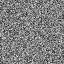

In [75]:
m = torch.rand(1,4,64,64).mean(dim=1)[0].cpu().numpy()
print(m.shape)
Image.fromarray((m * 255).round().astype("uint8"))

In [ ]:
m0 = torch.rand((64, 64), generator=torch.manual_seed(42))
m0 = gaussian_filter(m0, sigma=(1,1) )
m0 = m0 - m0.min()
m0 = m0 / m0.max()
# k[k<x] = k[k<x] + x * (1.0 - k[k<x])
# k[k<x] = (x - k[k>x]) / (1.0 - k[k>x])
# m[m<x] = (x - m[m<x]) / (1.0 - m[m<x])
# m[m>x] = 0
display(Image.fromarray((m0 * 255).round().astype("uint8")))
print(m0.mean(), m0.std(), m0.min(), m0.max())
frames = 30
for i in range(frames + 1):
  x = float(i) / float(frames)
  m = m0.copy()
  #m[m<x] = ((x - m[m<x]) / (1.0 - m[m<x]))
  #m[m>x] = 0
  #m = m ** 0.5

  m = gaussian_filter(m, sigma=(1,1) )
  m = m - m.min()
  m = m / m.max()
  
  softness = 0.1
  x /= 1.0 - softness
  m_zero_slice = m>x
  m[m<x] = np.clip(((x - m[m<x]) / softness),0.0,1.0)
  m[m_zero_slice] = 0

  img = Image.fromarray((m * 255).round().astype("uint8"))
  img = img.resize((512,512), resample=Image.NEAREST)
  save_img(img, f"{ROOT}/mask", f"mask_{i:04d}.png")

!ffmpeg -v 1 -y -f image2 -framerate 10 -i {ROOT}/mask/mask_%4d.png -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p {ROOT}/mask.mp4
#!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg                          -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open(f'{ROOT}/mask.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
  <source src="%s" type="video/mp4">
</video>
""" % data_url)